In [1]:
import torchvision
import torch.nn as nn
import torch
import torch.nn.functional as F
from torchvision import transforms, models, datasets
from torchsummary import summary
import numpy as np, pandas as pd, os, glob
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib
import glob
from sklearn import cluster
from sklearn.model_selection import train_test_split

In [2]:
%%!
git clone https://github.com/udacity/P1_Facial_Keypoints.git

["fatal: destination path 'P1_Facial_Keypoints' already exists and is not an empty directory."]

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
root_dir = "P1_Facial_Keypoints/data/training/"
all_img_paths = glob.glob(os.path.join(root_dir, "*.jpg"))
df = pd.read_csv("P1_Facial_Keypoints/data/training_frames_keypoints.csv")
df  # 每一行有136列, 每2列对应某一个点的x和y

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,126,127,128,129,130,131,132,133,134,135
0,Luis_Fonsi_21.jpg,45.0,98.0,47.0,106.0,49.0,110.0,53.0,119.0,56.0,...,83.0,119.0,90.0,117.0,83.0,119.0,81.0,122.0,77.0,122.0
1,Lincoln_Chafee_52.jpg,41.0,83.0,43.0,91.0,45.0,100.0,47.0,108.0,51.0,...,85.0,122.0,94.0,120.0,85.0,122.0,83.0,122.0,79.0,122.0
2,Valerie_Harper_30.jpg,56.0,69.0,56.0,77.0,56.0,86.0,56.0,94.0,58.0,...,79.0,105.0,86.0,108.0,77.0,105.0,75.0,105.0,73.0,105.0
3,Angelo_Reyes_22.jpg,61.0,80.0,58.0,95.0,58.0,108.0,58.0,120.0,58.0,...,98.0,136.0,107.0,139.0,95.0,139.0,91.0,139.0,85.0,136.0
4,Kristen_Breitweiser_11.jpg,58.0,94.0,58.0,104.0,60.0,113.0,62.0,121.0,67.0,...,92.0,117.0,103.0,118.0,92.0,120.0,88.0,122.0,84.0,122.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3457,Thomas_Ferguson_02.jpg,35.0,94.0,35.0,105.0,38.0,112.0,40.0,123.0,46.0,...,71.0,123.0,79.0,121.0,71.0,123.0,66.0,126.0,64.0,126.0
3458,Valerie_Harper_00.jpg,72.0,133.0,76.0,147.0,80.0,159.0,87.0,170.0,91.0,...,120.0,156.0,135.0,159.0,124.0,163.0,117.0,167.0,113.0,166.0
3459,Maggie_Smith_00.jpg,52.0,149.0,56.0,160.0,63.0,168.0,71.0,179.0,78.0,...,122.0,169.0,133.0,169.0,122.0,172.0,115.0,172.0,111.0,172.0
3460,Erin_Hershey_Presley_41.jpg,82.0,91.0,82.0,105.0,82.0,116.0,86.0,128.0,90.0,...,119.0,132.0,134.0,136.0,119.0,139.0,112.0,139.0,108.0,139.0


In [31]:
from torch.utils.data import TensorDataset, DataLoader, Dataset
import cv2, numpy as np
from copy import deepcopy


class FacesData(Dataset):
    def __init__(self, df):
        super(FacesData).__init__()
        self.df = df
        self.normalize = transforms.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
        )

    def __len__(self):
        return len(self.df)

    def __getitem__(self, ix):
        img_path = "P1_Facial_Keypoints/data/training/" + self.df.iloc[ix, 0]
        img = cv2.imread(img_path) / 255.0
        # 获取图片对应的keypoints值
        keypoints = deepcopy(self.df.iloc[ix, 1:].tolist())
        # 每一个点的x和y分别进行标准化, 变成0-1范围内
        keypoints_x = (np.array(keypoints[0::2]) / img.shape[1]).tolist()
        keypoints_y = (np.array(keypoints[1::2]) / img.shape[0]).tolist()

        list_keypoints = keypoints_x + keypoints_y  # 直接相连
        tensor_keypoints = torch.tensor(list_keypoints)
        img = self.preprocess_input(img)
        return img, tensor_keypoints

    def preprocess_input(self, img):
        img = cv2.resize(img, (224, 224))
        img = torch.tensor(img).permute(2, 0, 1)
        img = self.normalize(img).float()
        return img.to(device)

    def load_img(self, ix):
        img_path = "P1_Facial_Keypoints/data/training/" + self.df.iloc[ix, 0]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) / 255.0
        img = cv2.resize(img, (224, 224))
        return img


def train_batch(img, kps, model, optimizer, loss_fn):
    model.train()
    optimizer.zero_grad()
    _kps = model(img.to(device))
    loss = loss_fn(_kps, kps.to(device))
    loss.backward()
    optimizer.step()
    return loss


@torch.no_grad()
def validate_batch(img, kps, model, loss_fn):
    model.eval()
    _kps = model(img.to(device))
    loss = loss_fn(_kps, kps.to(device))
    return loss


def get_model():
    model = models.vgg16(weights=True)
    for param in model.parameters():
        param.requires_grad = False
    model.avgpool = nn.Sequential(nn.Conv2d(512, 512, 3), nn.MaxPool2d(2), nn.Flatten())
    model.classifier = nn.Sequential(
        nn.Linear(2048, 512),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(512, 136),
        nn.Sigmoid(),
    )
    loss_fn = nn.L1Loss()  # 使用平均绝对误差作为损失函数
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    return model.to(device), loss_fn, optimizer


train, test = train_test_split(df, test_size=0.2, random_state=101)
train_dataset = FacesData(train.reset_index(drop=True))
test_dataset = FacesData(test.reset_index(drop=True))

train_loader = DataLoader(train_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

In [33]:
model, loss_fn, optimizer = get_model()
train_loss, test_loss = [], []
n_epochs = 28
num_batch_train = len(train_loader)
num_batch_validate = len(test_loader)

for epoch in range(n_epochs):
    print(f"epoch {epoch+ 1}/{n_epochs}")
    epoch_train_loss, epoch_test_loss = 0, 0

    # Training
    model.train()
    for idx, (img, keypoints) in enumerate(train_loader, 1):
        print(f"\ttraining: {idx}/{num_batch_train}")
        loss = train_batch(img, keypoints, model, optimizer, loss_fn)
        epoch_train_loss += loss.item()
    epoch_train_loss /= idx

    # Validation
    model.eval()
    for idx, (img, keypoints) in enumerate(test_loader, 1):
        print(f"\tevaluating: {idx}/{num_batch_validate}")
        loss = validate_batch(img, keypoints, model, loss_fn)
        epoch_test_loss += loss.item()
    epoch_test_loss /= idx

    train_loss.append(epoch_train_loss)
    test_loss.append(epoch_test_loss)

epoch 1/28
	training: 1/87
	training: 2/87
	training: 3/87
	training: 4/87
	training: 5/87
	training: 6/87
	training: 7/87
	training: 8/87
	training: 9/87
	training: 10/87
	training: 11/87
	training: 12/87
	training: 13/87
	training: 14/87
	training: 15/87
	training: 16/87
	training: 17/87
	training: 18/87
	training: 19/87
	training: 20/87
	training: 21/87
	training: 22/87
	training: 23/87
	training: 24/87
	training: 25/87
	training: 26/87
	training: 27/87
	training: 28/87
	training: 29/87
	training: 30/87
	training: 31/87
	training: 32/87
	training: 33/87
	training: 34/87
	training: 35/87
	training: 36/87
	training: 37/87
	training: 38/87
	training: 39/87
	training: 40/87
	training: 41/87
	training: 42/87
	training: 43/87
	training: 44/87
	training: 45/87
	training: 46/87
	training: 47/87
	training: 48/87
	training: 49/87
	training: 50/87
	training: 51/87
	training: 52/87
	training: 53/87
	training: 54/87
	training: 55/87
	training: 56/87
	training: 57/87
	training: 58/87
	training: 5

In [ ]:
torch.save(model.to("cpu").state_dict(), "facial_detection.pth")

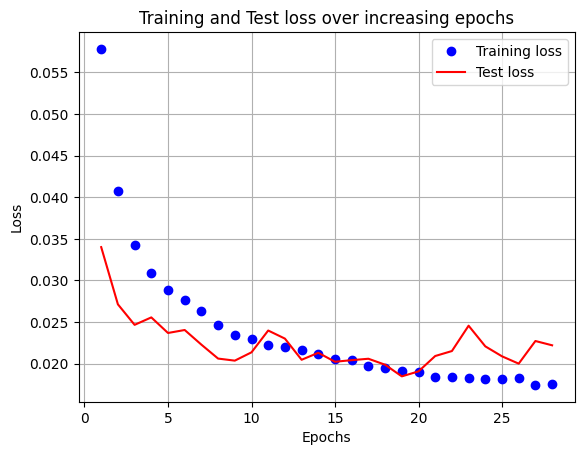

In [37]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline

epochs = np.arange(28)+1
plt.plot(epochs, train_loss, 'bo', label='Training loss')
plt.plot(epochs, test_loss, 'r', label='Test loss')
plt.title('Training and Test loss over increasing epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()

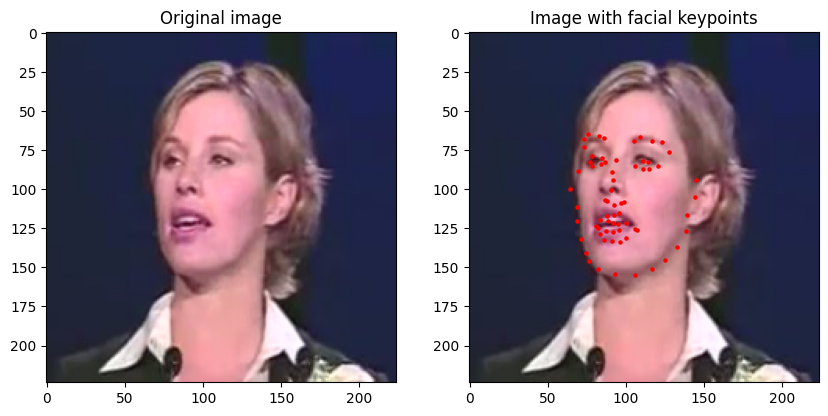

In [35]:
ix = 2

plt.figure(figsize=(10, 10))
plt.subplot(221)
plt.title("Original image")

im = train_dataset.load_img(ix)
plt.imshow(im)
plt.grid(False)
plt.subplot(222)
plt.title("Image with facial keypoints")
x, _ = train_dataset[ix]
plt.imshow(im)
kp = model(x[None]).flatten().detach().cpu()
plt.scatter(kp[:68] * 224, kp[68:] * 224, c="r", s=5)
plt.grid(False)
plt.show()